In [2]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [19]:
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import DeepFool
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist


In [5]:
# Step 0: Define the neural network model, return logits instead of activation in forward method
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x



In [6]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)


In [7]:
# Step 2: Create the model

model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)


In [8]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

In [9]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))


Accuracy on benign test examples: 97.57000000000001%


In [20]:
# Step 6: Generate adversarial test examples
attack_FGD = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv_FGD = attack_FGD.generate(x=x_test)
attack_DF=DeepFool(classifier=classifier)
x_test_adv_DF= attack_DF.generate(x=x_test)

DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]

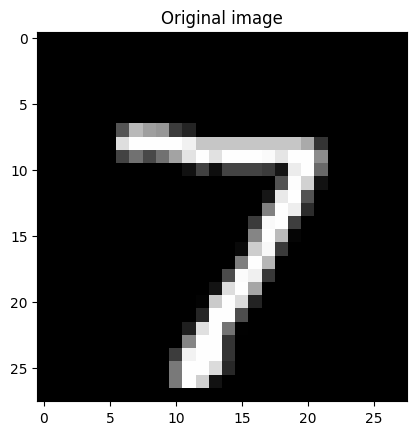

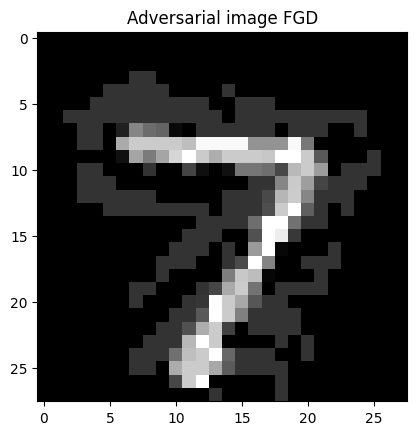

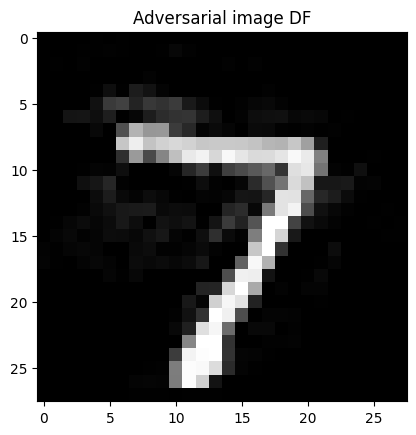

In [21]:
#visualize the image before attack
plt.imshow(np.transpose(x_test[0], (1, 2, 0)),cmap='gray')
plt.title("Original image")
plt.show()
# Visualize the first image in the test set after generating adversarial examples
plt.imshow(np.transpose(x_test_adv_FGD[0], (1, 2, 0)),cmap='gray')
plt.title("Adversarial image FGD")
plt.show()
plt.imshow(np.transpose(x_test_adv_DF[0], (1, 2, 0)),cmap='gray')
plt.title("Adversarial image DF")
plt.show()

In [11]:
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv_FGD)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples FGD: {}%".format(accuracy * 100))


Accuracy on adversarial test examples: 32.26%


In [22]:
predictions = classifier.predict(x_test_adv_DF)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples DF: {}%".format(accuracy * 100))

Accuracy on adversarial test examples DF: 2.6100000000000003%
